In [ ]:
"""读取数据"""

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 加载数据
data = pd.read_excel("车主之家.xlsx")

# 转换日期格式
data['时间'] = pd.to_datetime(data['时间'])
data.set_index('时间', inplace=True)

Epoch [10/100], Loss: 0.0810
Epoch [20/100], Loss: 0.0651
Epoch [30/100], Loss: 0.0307
Epoch [40/100], Loss: 0.0057
Epoch [50/100], Loss: 0.0057
Epoch [60/100], Loss: 0.0021
Epoch [70/100], Loss: 0.0019
Epoch [80/100], Loss: 0.0135
Epoch [90/100], Loss: 0.0013
Epoch [100/100], Loss: 0.0010


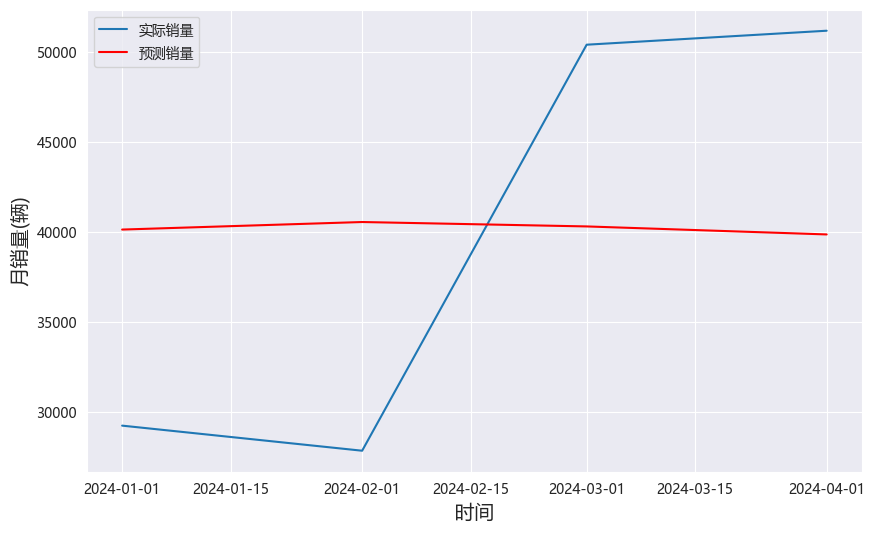

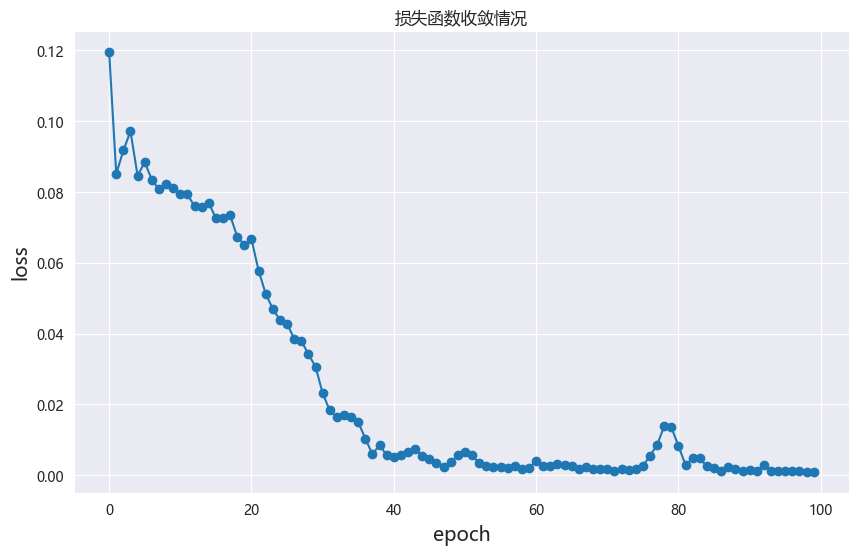

未来销量预测： 40387.977


In [66]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 数据加载和预处理
excel_data = {
    '时间': ['2024/4/1', '2024/3/1', '2024/2/1', '2024/1/1', '2023/12/1', '2023/11/1', '2023/10/1', '2023/9/1',
            '2023/8/1', '2023/7/1', '2023/6/1', '2023/5/1', '2023/4/1', '2023/3/1', '2023/2/1', '2023/1/1',
            '2022/12/1', '2022/11/1', '2022/10/1', '2022/9/1', '2022/8/1', '2022/7/1', '2022/6/1', '2022/5/1',
            '2022/4/1', '2022/3/1', '2022/2/1', '2022/1/1'],
    '月销量(辆)': [51170, 50394, 27851, 29244, 41142, 38054, 37902, 39904, 39808, 37129, 38197, 42887,
               39951, 40215, 27434, 11590, 23149, 25498, 32195, 36058, 35689, 30093, 23380, 17943,
               20292, 22942, 22508, 25535]
}
df = pd.DataFrame(excel_data)

# 时间排序并缩放到 [-1, 1] 范围
df['时间'] = pd.to_datetime(df['时间'], format='%Y/%m/%d')
df = df.sort_values('时间')
data = df[['月销量(辆)']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# 创建 LSTM 数据集
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(data_scaled, seq_length)

# 划分训练和测试集
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# 转换为 PyTorch 张量
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 定义 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 定义超参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

# 模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# 预测测试集
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_y.numpy())

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# 可视化预测结果
test_dates = df['时间'].iloc[train_size + seq_length:].reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actuals, label='实际销量')
plt.plot(test_dates, predictions, label='预测销量', color='red')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')
plt.legend()
plt.show()

# 绘制训练损失
sns.set_style("darkgrid", {"font.family": ['Microsoft YaHei', 'SimHei']})
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-')
plt.title('损失函数收敛情况')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

# 预测未来销量
model.eval()
future_seq = np.array(data_scaled[-seq_length:]).reshape(1, seq_length, input_size)
future_seq_tensor = torch.Tensor(future_seq).to(device)
future_pred = model(future_seq_tensor)
future_pred = scaler.inverse_transform(future_pred.detach().cpu().numpy().reshape(-1, 1))

print("未来销量预测：", future_pred[0][0])


Epoch [10/100], Loss: 0.0645
Epoch [20/100], Loss: 0.0296
Epoch [30/100], Loss: 0.0282
Epoch [40/100], Loss: 0.0268
Epoch [50/100], Loss: 0.0218
Epoch [60/100], Loss: 0.0174
Epoch [70/100], Loss: 0.0185
Epoch [80/100], Loss: 0.0137
Epoch [90/100], Loss: 0.0145
Epoch [100/100], Loss: 0.0108


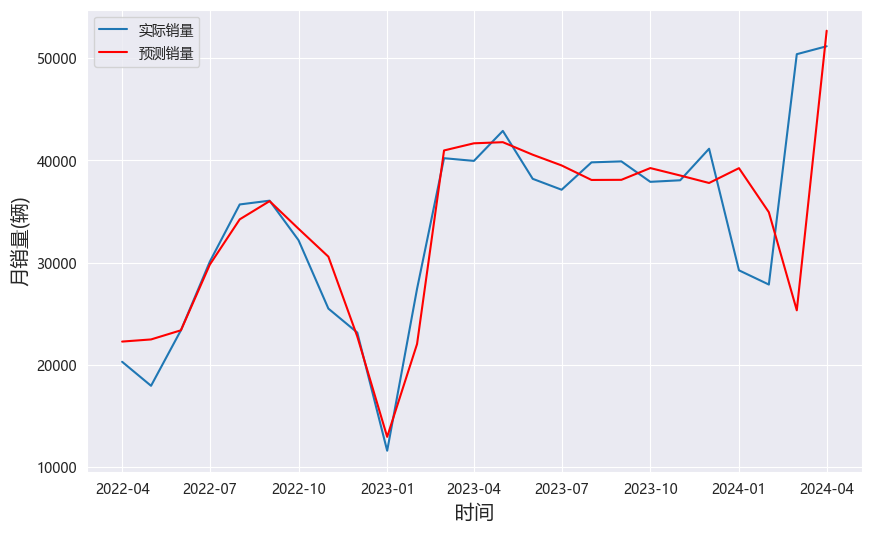

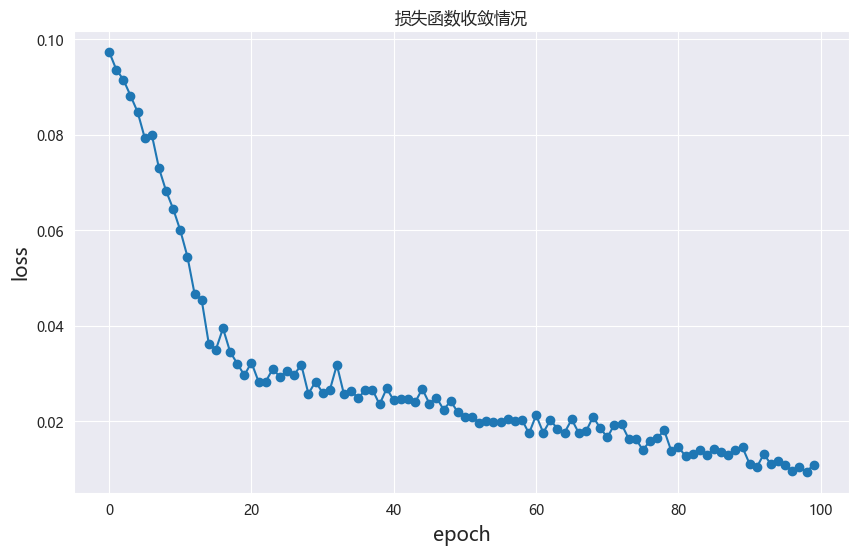

未来销量预测： 51598.883


In [71]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 数据加载和预处理
excel_data = {
    '时间': ['2024/4/1', '2024/3/1', '2024/2/1', '2024/1/1', '2023/12/1', '2023/11/1', '2023/10/1', '2023/9/1',
            '2023/8/1', '2023/7/1', '2023/6/1', '2023/5/1', '2023/4/1', '2023/3/1', '2023/2/1', '2023/1/1',
            '2022/12/1', '2022/11/1', '2022/10/1', '2022/9/1', '2022/8/1', '2022/7/1', '2022/6/1', '2022/5/1',
            '2022/4/1', '2022/3/1', '2022/2/1', '2022/1/1'],
    '月销量(辆)': [51170, 50394, 27851, 29244, 41142, 38054, 37902, 39904, 39808, 37129, 38197, 42887,
               39951, 40215, 27434, 11590, 23149, 25498, 32195, 36058, 35689, 30093, 23380, 17943,
               20292, 22942, 22508, 25535]
}
df = pd.DataFrame(excel_data)

# 时间排序并缩放到 [-1, 1] 范围
df['时间'] = pd.to_datetime(df['时间'], format='%Y/%m/%d')
df = df.sort_values('时间')
data = df[['月销量(辆)']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# 创建 LSTM 数据集
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X, y = create_sequences(data_scaled, seq_length)

# 划分训练和测试集
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# 转换为 PyTorch 张量
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 定义 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 定义超参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

# 模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# 预测整个数据集
model.eval()
all_predictions = []
with torch.no_grad():
    for i in range(len(X)):
        seq = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0).to(device)
        prediction = model(seq)
        all_predictions.append(prediction.cpu().numpy())

# 将所有预测结果逆缩放回原始范围
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(y.reshape(-1, 1))

# 将预测和实际数据绘制成整体曲线
dates = df['时间'].iloc[seq_length:].reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(dates, actuals, label='实际销量')
plt.plot(dates, all_predictions, label='预测销量', color='red')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')
plt.legend()
plt.show()

# 绘制训练损失
sns.set_style("darkgrid", {"font.family": ['Microsoft YaHei', 'SimHei']})
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-')
plt.title('损失函数收敛情况')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

# 预测未来销量
model.eval()
future_seq = np.array(data_scaled[-seq_length:]).reshape(1, seq_length, input_size)
future_seq_tensor = torch.Tensor(future_seq).to(device)
future_pred = model(future_seq_tensor)
future_pred = scaler.inverse_transform(future_pred.detach().cpu().numpy().reshape(-1, 1))

print("未来销量预测：", future_pred[0][0])


Epoch [10/100], Loss: 0.0921
Epoch [20/100], Loss: 0.0575
Epoch [30/100], Loss: 0.0573
Epoch [40/100], Loss: 0.0569
Epoch [50/100], Loss: 0.0484
Epoch [60/100], Loss: 0.0382
Epoch [70/100], Loss: 0.0221
Epoch [80/100], Loss: 0.0167
Epoch [90/100], Loss: 0.0131
Epoch [100/100], Loss: 0.0105


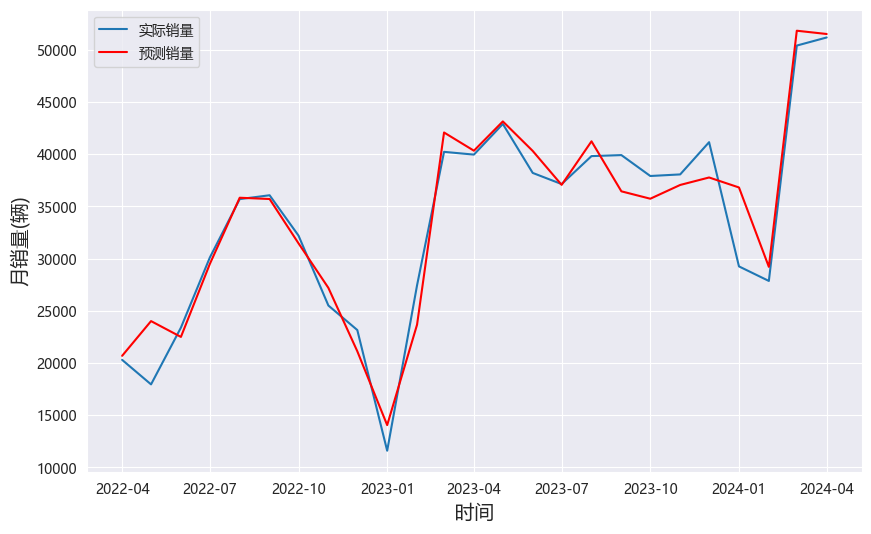

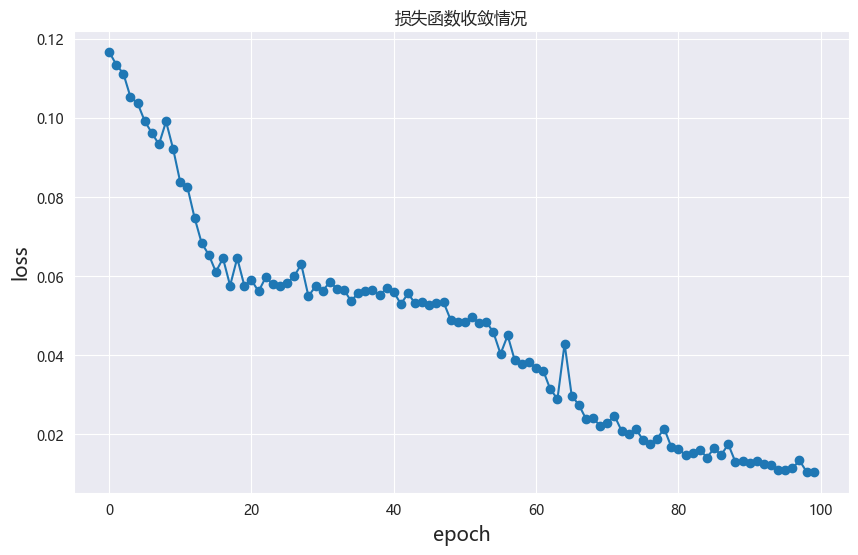

未来销量预测： 55163.867


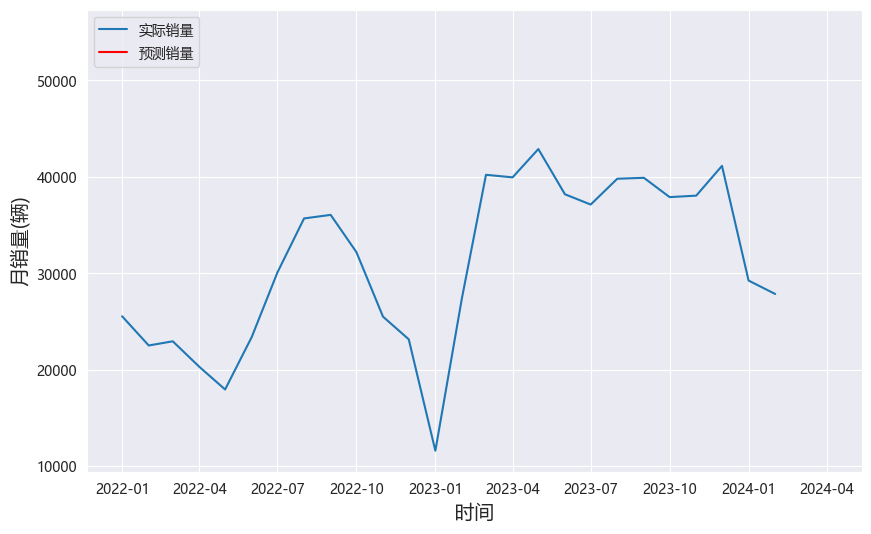

In [73]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 数据加载和预处理
excel_data = {
    '时间': ['2024/4/1', '2024/3/1', '2024/2/1', '2024/1/1', '2023/12/1', '2023/11/1', '2023/10/1', '2023/9/1',
            '2023/8/1', '2023/7/1', '2023/6/1', '2023/5/1', '2023/4/1', '2023/3/1', '2023/2/1', '2023/1/1',
            '2022/12/1', '2022/11/1', '2022/10/1', '2022/9/1', '2022/8/1', '2022/7/1', '2022/6/1', '2022/5/1',
            '2022/4/1', '2022/3/1', '2022/2/1', '2022/1/1'],
    '月销量(辆)': [51170, 50394, 27851, 29244, 41142, 38054, 37902, 39904, 39808, 37129, 38197, 42887,
               39951, 40215, 27434, 11590, 23149, 25498, 32195, 36058, 35689, 30093, 23380, 17943,
               20292, 22942, 22508, 25535]
}
df = pd.DataFrame(excel_data)

# 时间排序并缩放到 [-1, 1] 范围
df['时间'] = pd.to_datetime(df['时间'], format='%Y/%m/%d')
df = df.sort_values('时间')
data = df[['月销量(辆)']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# 创建 LSTM 数据集
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X, y = create_sequences(data_scaled, seq_length)

# 转换为 PyTorch 张量
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# 定义 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 定义超参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

# 模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(loader)
    losses.append(avg_epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# 预测整个数据集
model.eval()
all_predictions = []
with torch.no_grad():
    for i in range(len(X)):
        seq = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0).to(device)
        prediction = model(seq)
        all_predictions.append(prediction.cpu().numpy())

# 将所有预测结果逆缩放回原始范围
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(y.reshape(-1, 1))

# 将预测和实际数据绘制成整体曲线
dates = df['时间'].iloc[seq_length:].reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(dates, actuals, label='实际销量')
plt.plot(dates, all_predictions, label='预测销量', color='red')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')
plt.legend()
plt.show()

# 绘制训练损失
sns.set_style("darkgrid", {"font.family": ['Microsoft YaHei', 'SimHei']})
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-')
plt.title('损失函数收敛情况')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

# 预测未来销量
model.eval()
future_seq = np.array(data_scaled[-seq_length:]).reshape(1, seq_length, input_size)
future_seq_tensor = torch.Tensor(future_seq).to(device)
future_pred = model(future_seq_tensor)
future_pred = scaler.inverse_transform(future_pred.detach().cpu().numpy().reshape(-1, 1))

# 预测下一个月的时间
next_month = df['时间'].iloc[-1] + pd.DateOffset(months=1)
print("未来销量预测：", future_pred[0][0])

# 将未来预测结果添加到原始数据中并可视化
df.loc[df.index[-1] + 1] = [next_month, np.nan]
df['预测销量(辆)'] = np.nan
df.loc[df.index[-1], '预测销量(辆)'] = future_pred[0][0]

plt.figure(figsize=(10, 6))
plt.plot(df['时间'], df['月销量(辆)'], label='实际销量')
plt.plot(df['时间'], df['预测销量(辆)'], label='预测销量', color='red')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')
plt.legend()
plt.show()


Epoch [10/100], Loss: 0.0927
Epoch [20/100], Loss: 0.0582
Epoch [30/100], Loss: 0.0558
Epoch [40/100], Loss: 0.0564
Epoch [50/100], Loss: 0.0510
Epoch [60/100], Loss: 0.0369
Epoch [70/100], Loss: 0.0204
Epoch [80/100], Loss: 0.0188
Epoch [90/100], Loss: 0.0129
Epoch [100/100], Loss: 0.0097


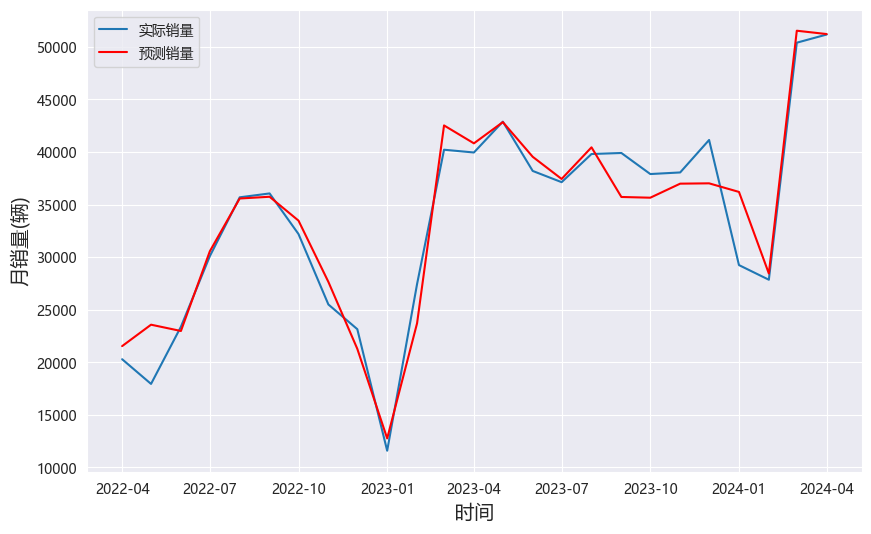

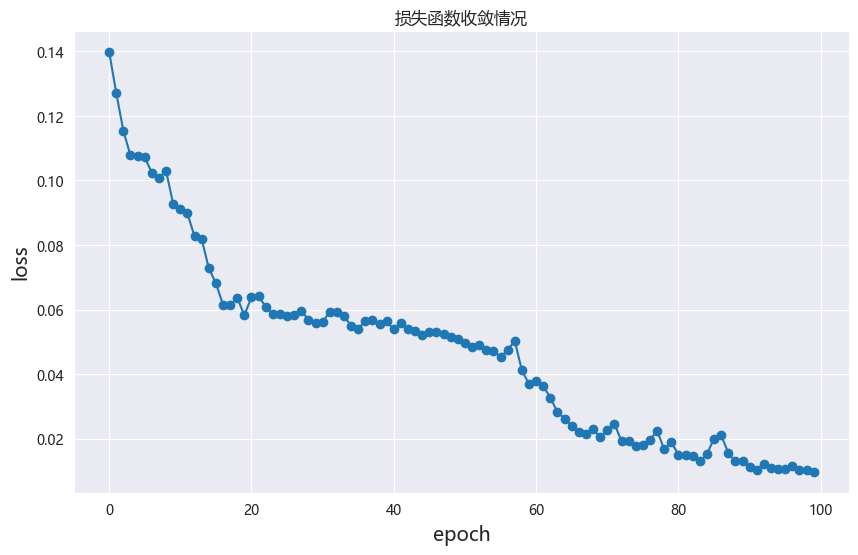

未来销量预测： 50914.99


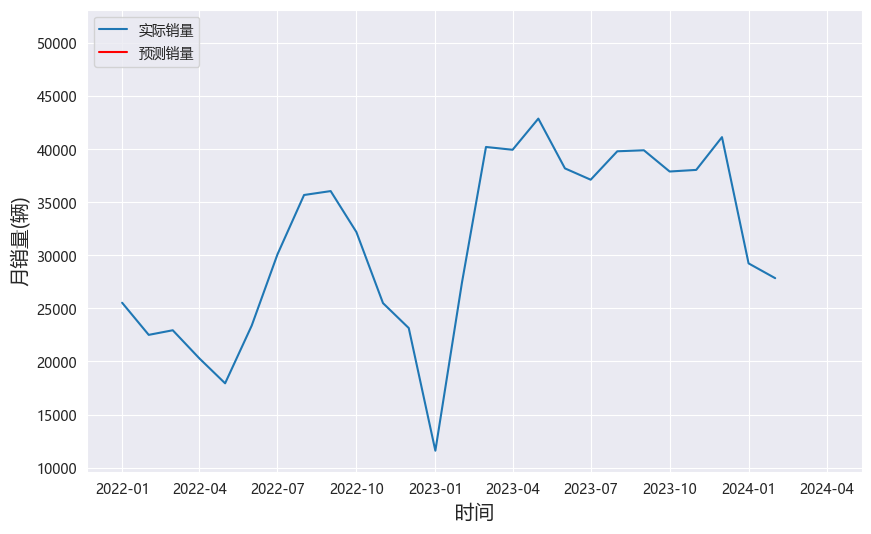

In [75]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 数据加载和预处理
excel_data = {
    '时间': ['2024/4/1', '2024/3/1', '2024/2/1', '2024/1/1', '2023/12/1', '2023/11/1', '2023/10/1', '2023/9/1',
            '2023/8/1', '2023/7/1', '2023/6/1', '2023/5/1', '2023/4/1', '2023/3/1', '2023/2/1', '2023/1/1',
            '2022/12/1', '2022/11/1', '2022/10/1', '2022/9/1', '2022/8/1', '2022/7/1', '2022/6/1', '2022/5/1',
            '2022/4/1', '2022/3/1', '2022/2/1', '2022/1/1'],
    '月销量(辆)': [51170, 50394, 27851, 29244, 41142, 38054, 37902, 39904, 39808, 37129, 38197, 42887,
               39951, 40215, 27434, 11590, 23149, 25498, 32195, 36058, 35689, 30093, 23380, 17943,
               20292, 22942, 22508, 25535]
}
df = pd.DataFrame(excel_data)

# 时间排序并缩放到 [-1, 1] 范围
df['时间'] = pd.to_datetime(df['时间'], format='%Y/%m/%d')
df = df.sort_values('时间')
data = df[['月销量(辆)']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# 创建 LSTM 数据集
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X, y = create_sequences(data_scaled, seq_length)

# 转换为 PyTorch 张量
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# 定义 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 定义超参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

# 模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(loader)
    losses.append(avg_epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# 预测整个数据集
model.eval()
all_predictions = []
with torch.no_grad():
    for i in range(len(X)):
        seq = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0).to(device)
        prediction = model(seq)
        all_predictions.append(prediction.cpu().numpy())

# 将所有预测结果逆缩放回原始范围
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(y.reshape(-1, 1))

# 将预测和实际数据绘制成整体曲线
dates = df['时间'].iloc[seq_length:].reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(dates, actuals, label='实际销量')
plt.plot(dates, all_predictions, label='预测销量', color='red')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')
plt.legend()
plt.show()

# 绘制训练损失
sns.set_style("darkgrid", {"font.family": ['Microsoft YaHei', 'SimHei']})
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-')
plt.title('损失函数收敛情况')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

# 预测未来销量
model.eval()
future_seq = np.array(data_scaled[-seq_length:]).reshape(1, seq_length, input_size)
future_seq_tensor = torch.Tensor(future_seq).to(device)
future_pred = model(future_seq_tensor)
future_pred = scaler.inverse_transform(future_pred.detach().cpu().numpy().reshape(-1, 1))

# 预测下一个月的时间
next_month = df['时间'].iloc[-1] + pd.DateOffset(months=1)
print("未来销量预测：", future_pred[0][0])

# 将未来预测结果添加到原始数据中并可视化
df.loc[df.index[-1] + 1] = [next_month, np.nan]
df['预测销量(辆)'] = np.nan
df.loc[df.index[-1], '预测销量(辆)'] = future_pred[0][0]

plt.figure(figsize=(10, 6))
plt.plot(df['时间'], df['月销量(辆)'], label='实际销量')
plt.plot(df['时间'], df['预测销量(辆)'], label='预测销量', color='red')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')
plt.legend()
plt.show()


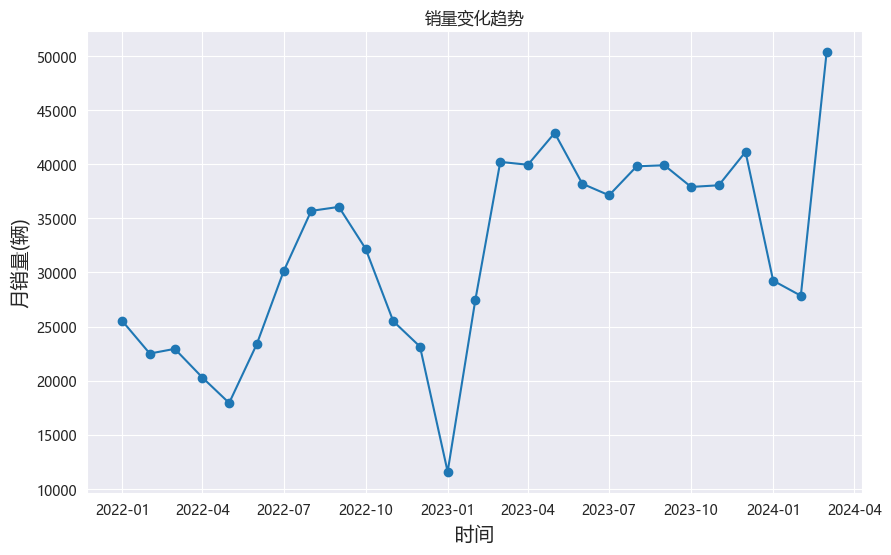

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#设置全局默认字体 为 雅黑
plt.rcParams['font.family'] = ['Microsoft YaHei'] 
# 设置全局轴标签字典大小
plt.rcParams["axes.labelsize"] = 14  
# 设置背景
sns.set_style("darkgrid",{"font.family":['Microsoft YaHei', 'SimHei']})  

# 加载数据
data = pd.read_excel("车主之家.xlsx")
# 将第一列转换为日期时间格式
data['时间'] = pd.to_datetime(data['时间'])

# 创建图形和轴对象
plt.figure(figsize=(10, 6))

# 绘制数据
plt.plot(data['时间'], data['月销量(辆)'], marker='o', linestyle='-')

# 添加标题和标签
plt.title('销量变化趋势')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')

# 添加网格
plt.grid(True)

# 显示图形
plt.show()


In [45]:
data

,月销量(辆)
时间,
2024-03-01,50394
2024-02-01,27851
2024-01-01,29244
2023-12-01,41142
2023-11-01,38054
2023-10-01,37902
2023-09-01,39904
2023-08-01,39808
2023-07-01,37129


In [56]:
future_pred=50211

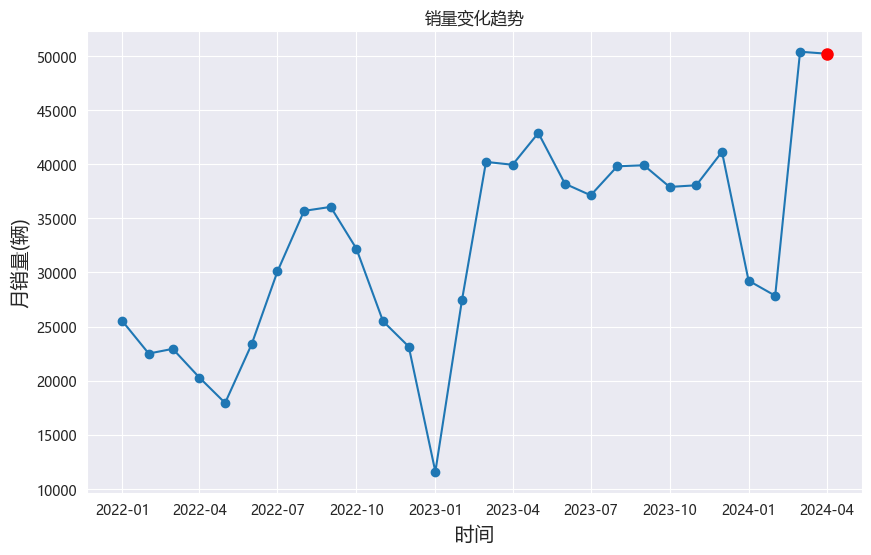

In [57]:
new_sales = future_pred
new_time = '2024-04-01'

# 创建一个新的DataFrame，包含新的销量和时间
new_row = pd.DataFrame({'时间': [new_time], '月销量(辆)': [new_sales]})

# 加载数据
data = pd.read_excel("车主之家.xlsx")
data=pd.concat([ new_row,data], ignore_index=True)
# 将第一列转换为日期时间格式
data['时间'] = pd.to_datetime(data['时间'])

# 创建图形和轴对象
plt.figure(figsize=(10, 6))

# 绘制数据
plt.plot(data['时间'], data['月销量(辆)'], marker='o', linestyle='-')
# 将最后一个点标红
plt.plot(data['时间'].iloc[0], data['月销量(辆)'].iloc[0], marker='o', linestyle='', color='red', markersize=8)

# 添加标题和标签
plt.title('销量变化趋势')
plt.xlabel('时间')
plt.ylabel('月销量(辆)')

# 添加网格
plt.grid(True)

# 显示图形
plt.show()

In [ ]:
import torch
import torch.nn as nn

# 假设你有一些预测值 pred 和目标值 target
pred = torch.tensor([0.5, 0.7, 0.3])
target = torch.tensor([0.4, 0.8, 0.2])

# 计算平方误差
squared_error = (pred - target) ** 2

# 计算均方根误差
rmse = torch.sqrt(torch.mean(squared_error))

print("均方根误差（RMSE）:", rmse.item())
